In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from helper import *
from plots import *
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
from functions import *
from imblearn.pipeline import Pipeline
import functions
import importlib
importlib.reload(functions)  # чтобы изменения в functions.py подхватились
import os

In [7]:
SEED = 42

In [11]:
#Cчитываем датасет
df = pd.read_csv(f"d:\Classification_project\weatherAUS.csv")
print(df.head())

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\dima2\AppData\Local\Temp\ipykernel_16168\3749640314.py:2: SyntaxWarning: invalid escape sequence '\C'
  df = pd.read_csv(f"d:\Classification_project\weatherAUS.csv")


         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

In [12]:
X, y, X_train, y_train, X_test, y_test, X_train_preprocessed, X_test_preprocessed = EDA_preprocess(df)#Функция которая делает начальную предобработку данных

In [13]:
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=10)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=SEED))
]

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [15]:
initial_metrics = evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8365
Precision: 0.7871
Recall:    0.6972
F1 Score:  0.7248
ROC AUC:   0.8434

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8393
Precision: 0.7849
Recall:    0.7133
F1 Score:  0.7379
ROC AUC:   0.8402

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8549
Precision: 0.8173
Recall:    0.7327
F1 Score:  0.7615
ROC AUC:   0.8805

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8482
Precision: 0.8061
Recall:    0.7204
F1 Score:  0.7488
ROC AUC:   0.8665

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8549     0.8173  0.7327 0.7615   0.8805
GradientBoostingClassifier    0.8482     0.8061  0.7204 0.7488   0.8665
LogisticRegression            0.8365     0.7871  0.6972 0.7248   0.8434
DecisionTreeClassifier        0.8393     0.7849  0.7133 0.7379   0.8402


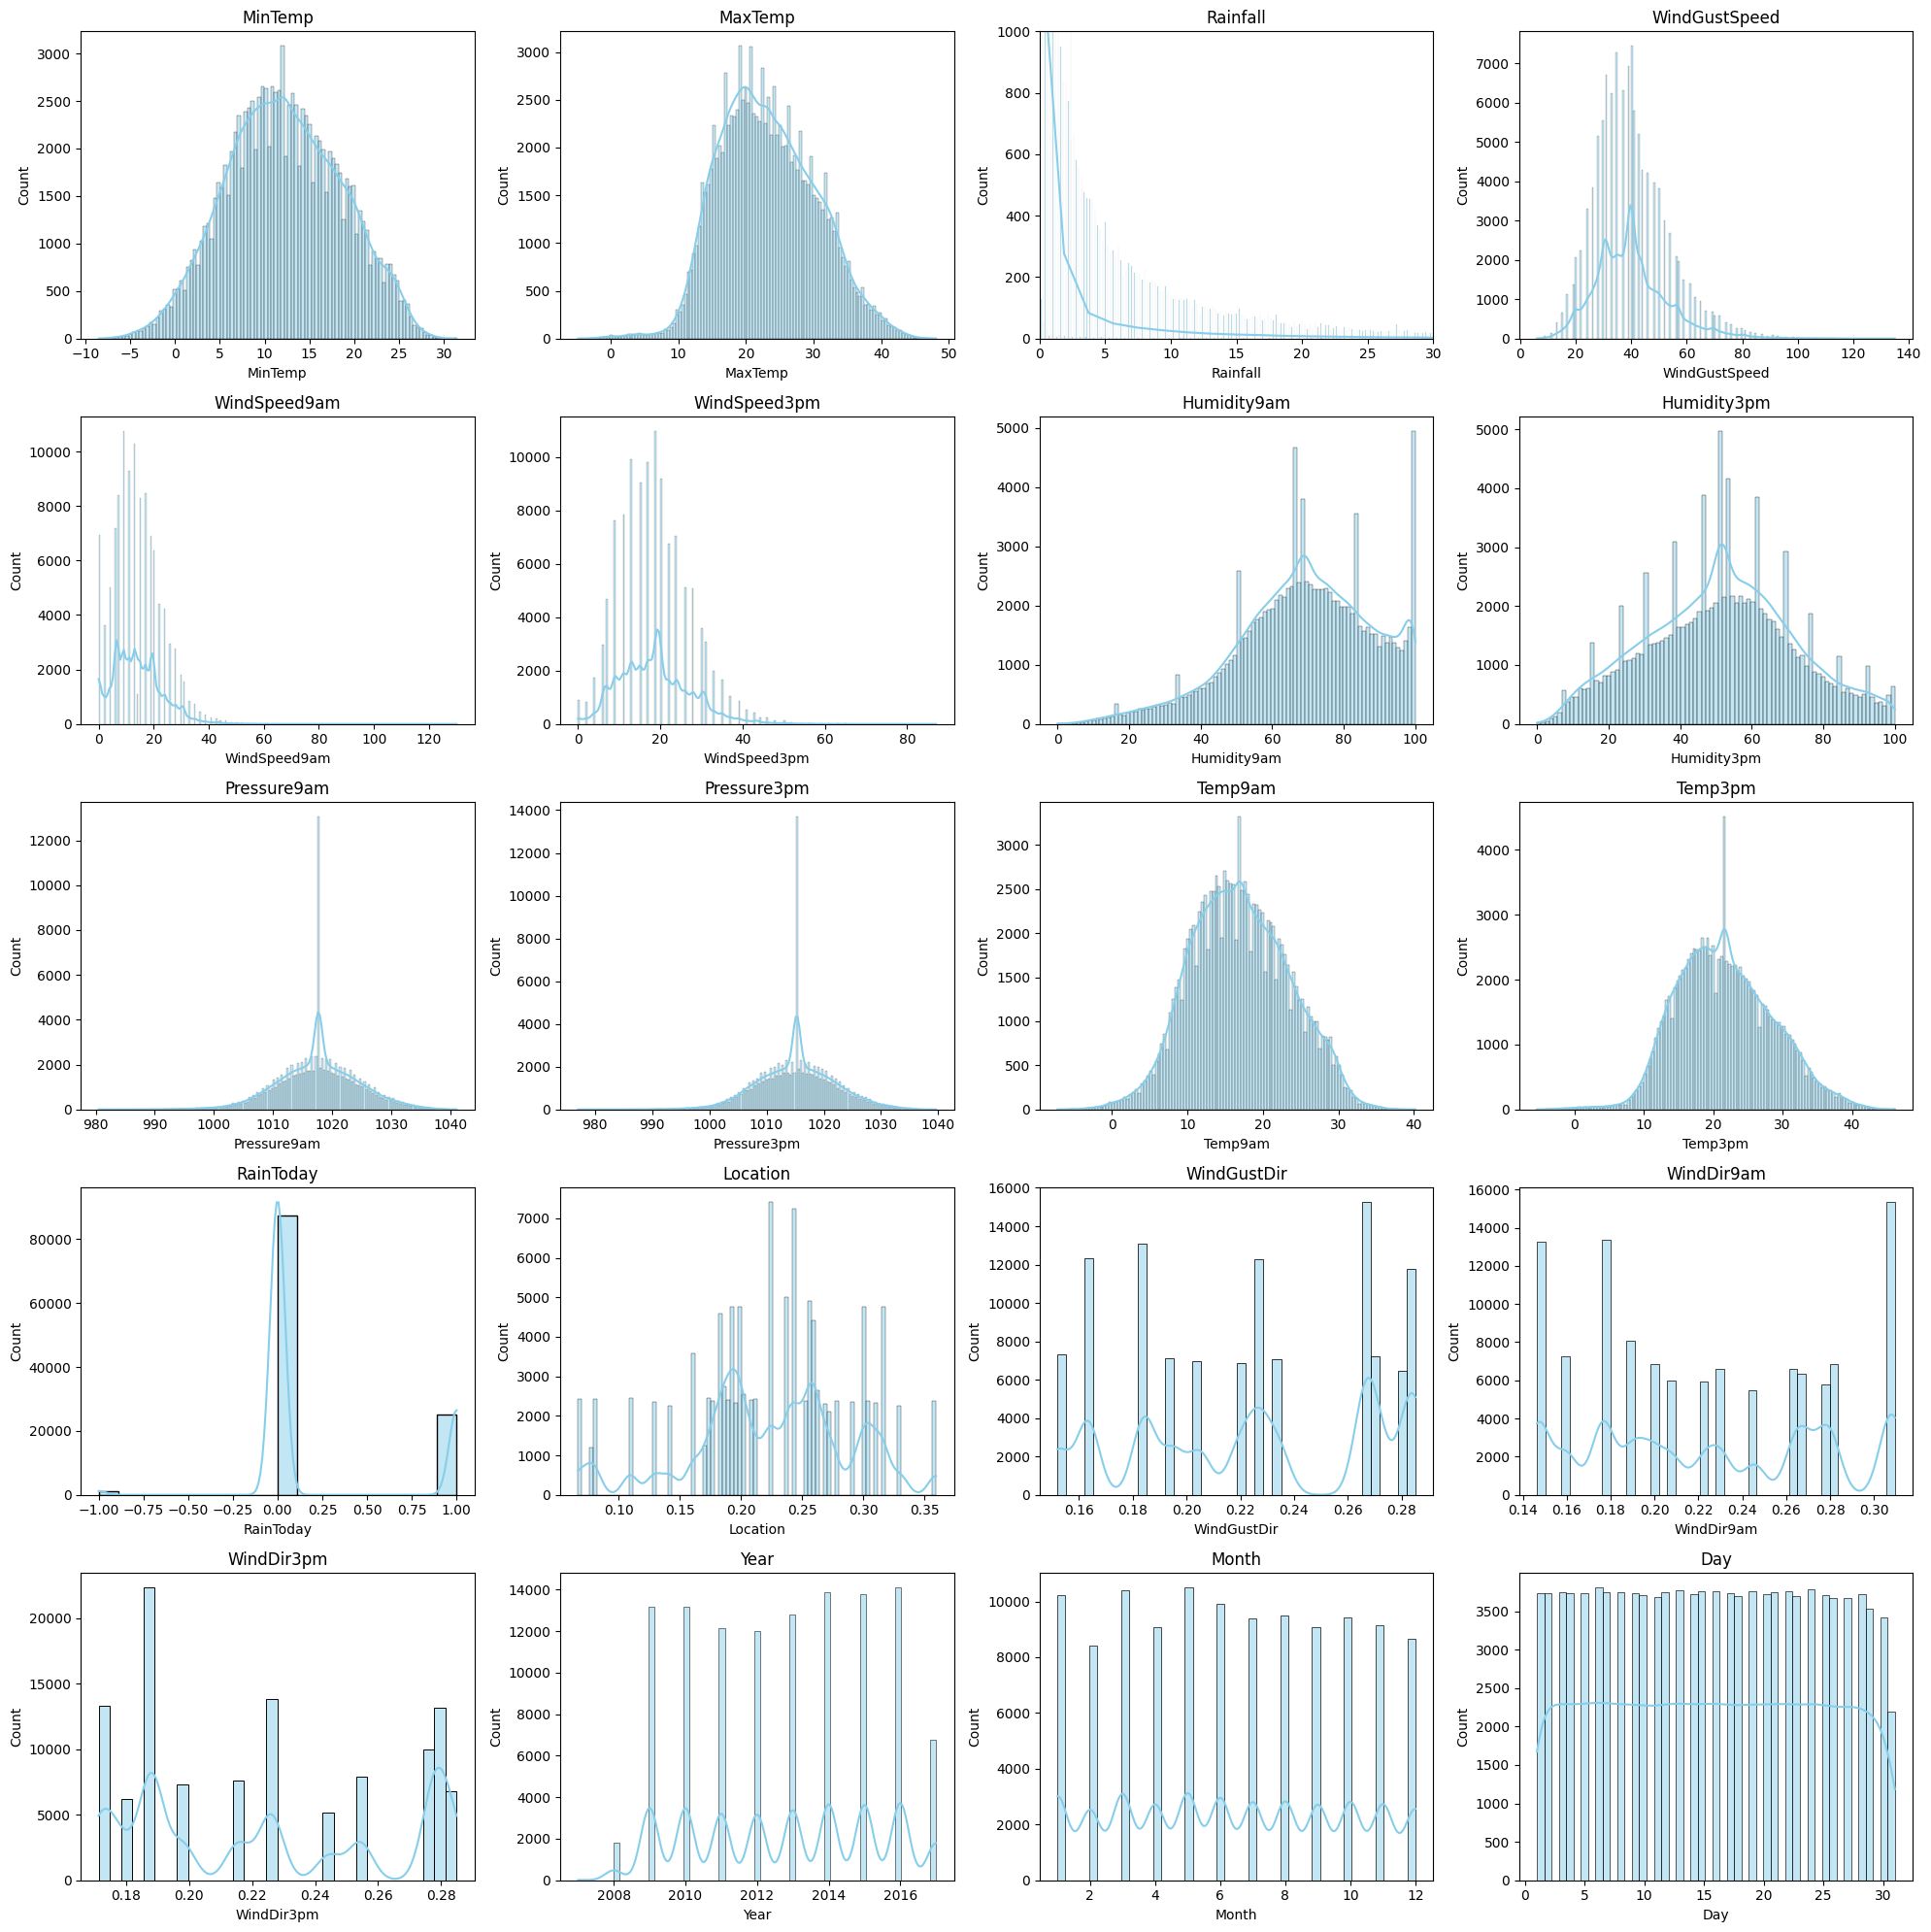

In [13]:
num_cols =X_train_preprocessed.select_dtypes(include='number').columns  # только числовые
n_cols = 4  # число графиков в одном ряду
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if col == 'Rainfall':
        axes[i].set_ylim(0, 1000)  # задаём лимит через axes[i]
        axes[i].set_xlim(0, 30)
    sns.histplot(X_train_preprocessed[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)

# Оставшиеся пустые графики скрываем
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
#Видим нормальное распределение у большинства признаков


In [16]:
X_train_preprocessed_skewed = X.copy()

In [17]:
#Добавим колонки для признаков у которых ненормальное распределение тем самым попробуем улучшеть результаты модели
X_train_preprocessed_skewed['Raifall_Log'] = np.log1p(X_train_preprocessed_skewed['Rainfall'])
X_train_preprocessed_skewed['WindSpeed9am_Log'] = np.log1p(X_train_preprocessed_skewed['WindSpeed9am'])
X_train_preprocessed_skewed['Humidity9am_square']=X_train_preprocessed_skewed['Humidity9am']**2

In [18]:
log_metrics = evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_skewed,
    y=y,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8363
Precision: 0.7872
Recall:    0.6963
F1 Score:  0.7240
ROC AUC:   0.8410

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8390
Precision: 0.7843
Recall:    0.7129
F1 Score:  0.7375
ROC AUC:   0.8398

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8536
Precision: 0.8152
Recall:    0.7302
F1 Score:  0.7590
ROC AUC:   0.8785

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8480
Precision: 0.8059
Recall:    0.7200
F1 Score:  0.7484
ROC AUC:   0.8665

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8536     0.8152  0.7302 0.7590   0.8785
GradientBoostingClassifier    0.8480     0.8059  0.7200 0.7484   0.8665
LogisticRegression            0.8363     0.7872  0.6963 0.7240   0.8410
DecisionTreeClassifier        0.8390     0.7843  0.7129 0.7375   0.8398



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0013    -0.0021 -0.0025 -0.0025  -0.0020
GradientBoostingClassifier   -0.0002    -0.0002 -0.0004 -0.0004   0.0000
LogisticRegression           -0.0002     0.0001 -0.0009 -0.0008  -0.0024
DecisionTreeClassifier       -0.0003    -0.0006 -0.0004 -0.0005  -0.0004


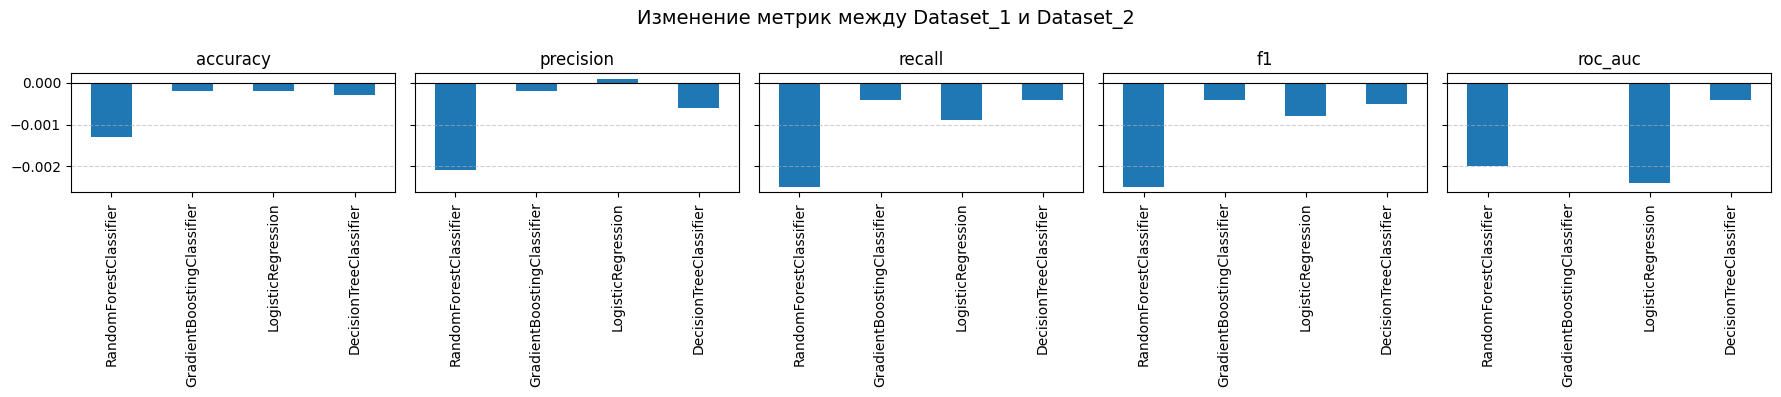

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0013,-0.0021,-0.0025,-0.0025,-0.0020
GradientBoostingClassifier,-0.0002,-0.0002,-0.0004,-0.0004,0.0000
LogisticRegression,-0.0002,0.0001,-0.0009,-0.0008,-0.0024
DecisionTreeClassifier,-0.0003,-0.0006,-0.0004,-0.0005,-0.0004


In [19]:
compare_datasets_results(initial_metrics, log_metrics)#Изменений почти нет

In [20]:
#Оставляем лог признаки на месте и удаляем изначальные вариации, проверим как изменятся результаты модели
X_train_preprocessed_skewed_delete = X_train_preprocessed_skewed.copy()
X_train_preprocessed_skewed_delete.drop(['Rainfall', 'WindSpeed9am', 'Humidity9am'], axis=1, inplace=True)


In [21]:
log_metrics_delete =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_skewed_delete,
    y=y,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8366
Precision: 0.7851
Recall:    0.7006
F1 Score:  0.7274
ROC AUC:   0.8439

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8388
Precision: 0.7842
Recall:    0.7123
F1 Score:  0.7369
ROC AUC:   0.8410

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8535
Precision: 0.8149
Recall:    0.7302
F1 Score:  0.7590
ROC AUC:   0.8800

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8477
Precision: 0.8054
Recall:    0.7192
F1 Score:  0.7476
ROC AUC:   0.8664

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8535     0.8149  0.7302 0.7590   0.8800
GradientBoostingClassifier    0.8477     0.8054  0.7192 0.7476   0.8664
LogisticRegression            0.8366     0.7851  0.7006 0.7274   0.8439
DecisionTreeClassifier        0.8388     0.7842  0.7123 0.7369   0.8410



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0014    -0.0025 -0.0024 -0.0026  -0.0005
GradientBoostingClassifier   -0.0005    -0.0007 -0.0013 -0.0012  -0.0000
LogisticRegression            0.0001    -0.0021  0.0034  0.0026   0.0005
DecisionTreeClassifier       -0.0005    -0.0007 -0.0010 -0.0010   0.0008


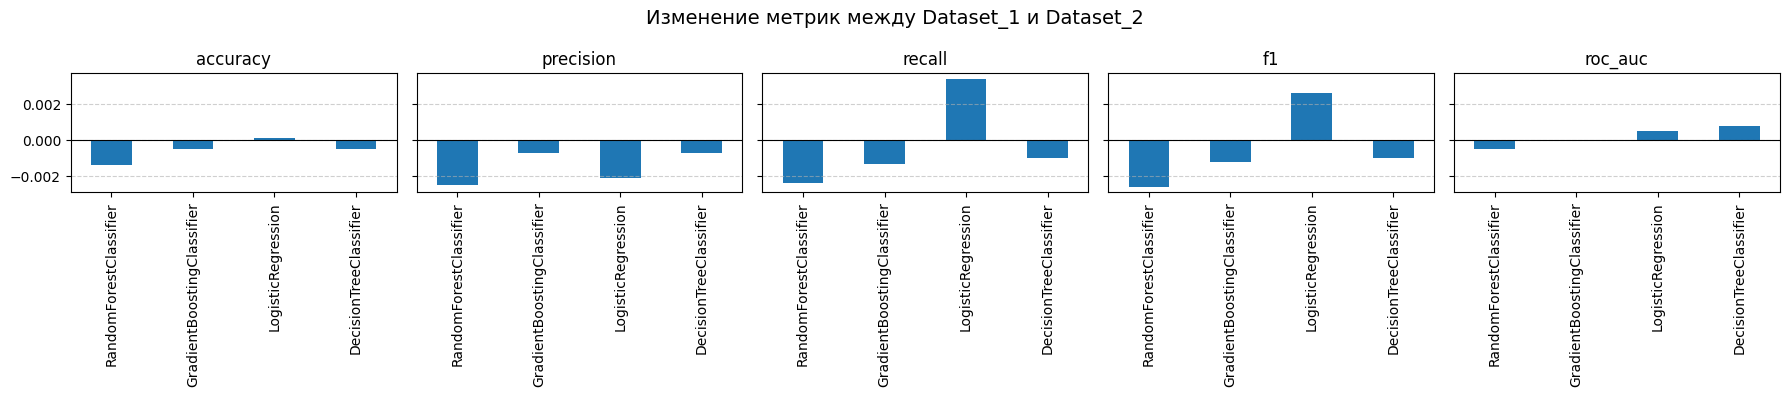

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0014,-0.0025,-0.0024,-0.0026,-0.0005
GradientBoostingClassifier,-0.0005,-0.0007,-0.0013,-0.0012,-0.0000
LogisticRegression,0.0001,-0.0021,0.0034,0.0026,0.0005
DecisionTreeClassifier,-0.0005,-0.0007,-0.0010,-0.0010,0.0008


In [22]:
compare_datasets_results(initial_metrics, log_metrics_delete)
#Видим что при удалении результаты только ухудшились у всех кроме лин рег

In [23]:
#Добавляем разницу между мин макс температурой и разницу по времени у других признаков, так как это может влиять на прогноз модели
X_train_preprocessed_diff = X.copy()
X_train_preprocessed_diff['Temp_diff'] = X_train_preprocessed_diff['Temp3pm'] - X_train_preprocessed_diff['Temp9am']
X_train_preprocessed_diff['Humidity_diff'] = X_train_preprocessed_diff['Humidity3pm'] - X_train_preprocessed_diff['Humidity9am']
X_train_preprocessed_diff['Pressure_diff'] = X_train_preprocessed_diff['Pressure3pm'] - X_train_preprocessed_diff['Pressure9am']
X_train_preprocessed_diff['Wind_diff'] = X_train_preprocessed_diff['WindSpeed3pm'] - X_train_preprocessed_diff['WindSpeed9am']
X_train_preprocessed_diff['Max_Min_Temp_diff'] = X_train_preprocessed_diff['MaxTemp']-X_train_preprocessed_diff['MinTemp']


In [24]:
Diff_metrics =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_diff,
    y=y,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8367
Precision: 0.7870
Recall:    0.6983
F1 Score:  0.7257
ROC AUC:   0.8443

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8384
Precision: 0.7822
Recall:    0.7138
F1 Score:  0.7376
ROC AUC:   0.8385

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8548
Precision: 0.8179
Recall:    0.7314
F1 Score:  0.7606
ROC AUC:   0.8813

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8494
Precision: 0.8078
Recall:    0.7230
F1 Score:  0.7513
ROC AUC:   0.8707

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8548     0.8179  0.7314 0.7606   0.8813
GradientBoostingClassifier    0.8494     0.8078  0.7230 0.7513   0.8707
LogisticRegression            0.8367     0.7870  0.6983 0.7257   0.8443
DecisionTreeClassifier        0.8384     0.7822  0.7138 0.7376   0.8385



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0002     0.0005 -0.0013 -0.0009   0.0008
GradientBoostingClassifier    0.0012     0.0017  0.0025  0.0025   0.0042
LogisticRegression            0.0002    -0.0002  0.0011  0.0009   0.0009
DecisionTreeClassifier       -0.0009    -0.0027  0.0005 -0.0003  -0.0017


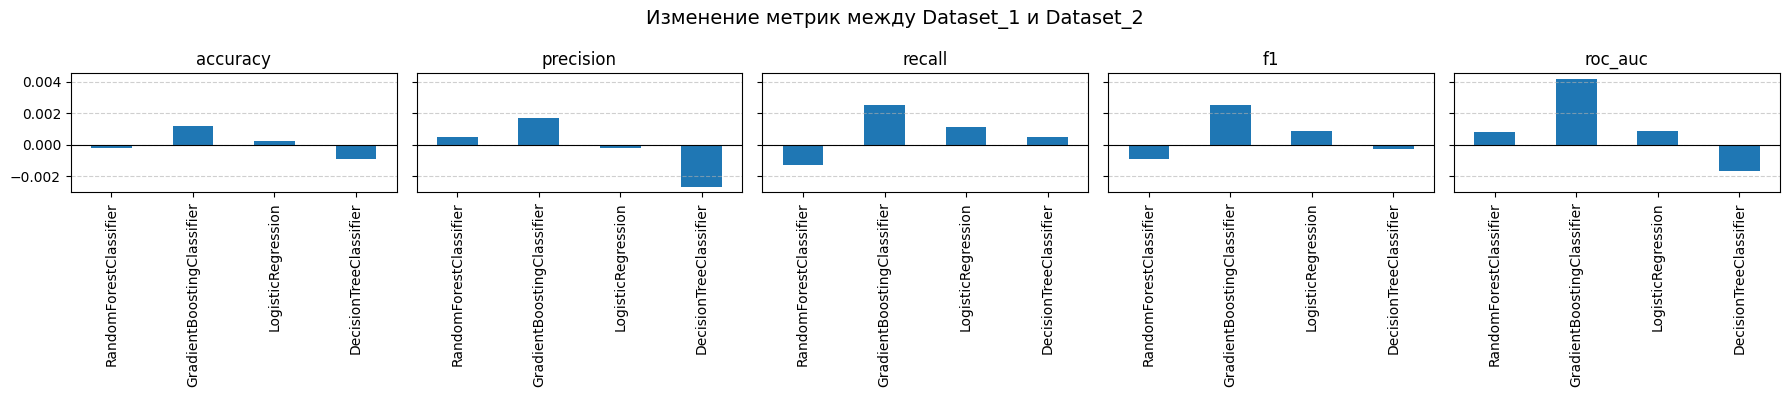

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0002,0.0005,-0.0013,-0.0009,0.0008
GradientBoostingClassifier,0.0012,0.0017,0.0025,0.0025,0.0042
LogisticRegression,0.0002,-0.0002,0.0011,0.0009,0.0009
DecisionTreeClassifier,-0.0009,-0.0027,0.0005,-0.0003,-0.0017


In [25]:
compare_datasets_results(initial_metrics, Diff_metrics)#Видим улучшение результатов на логистической регрессии и градиентном бустинге

In [26]:
#Теперь удаляем столбцы из которых делали новые фичи
X_train_preprocessed_diff_delete = X_train_preprocessed_diff.copy()

X_train_preprocessed_diff_delete.drop(['Temp3pm', 'Temp9am', 'Humidity3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'WindSpeed3pm', 'WindSpeed9am'], axis=1, inplace=True)


In [27]:
Diff_metrics_delete =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_diff_delete,
    y=y,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8191
Precision: 0.7623
Recall:    0.6534
F1 Score:  0.6788
ROC AUC:   0.8029

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8209
Precision: 0.7561
Recall:    0.6720
F1 Score:  0.6962
ROC AUC:   0.8072

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8409
Precision: 0.7964
Recall:    0.7034
F1 Score:  0.7321
ROC AUC:   0.8542

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8333
Precision: 0.7865
Recall:    0.6847
F1 Score:  0.7132
ROC AUC:   0.8396

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8409     0.7964  0.7034 0.7321   0.8542
GradientBoostingClassifier    0.8333     0.7865  0.6847 0.7132   0.8396
DecisionTreeClassifier        0.8209     0.7561  0.6720 0.6962   0.8072
LogisticRegression            0.8191     0.7623  0.6534 0.6788   0.8029



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0140    -0.0209 -0.0293 -0.0294  -0.0263
GradientBoostingClassifier   -0.0149    -0.0197 -0.0357 -0.0356  -0.0269
LogisticRegression           -0.0174    -0.0249 -0.0438 -0.0459  -0.0405
DecisionTreeClassifier       -0.0184    -0.0287 -0.0413 -0.0418  -0.0330


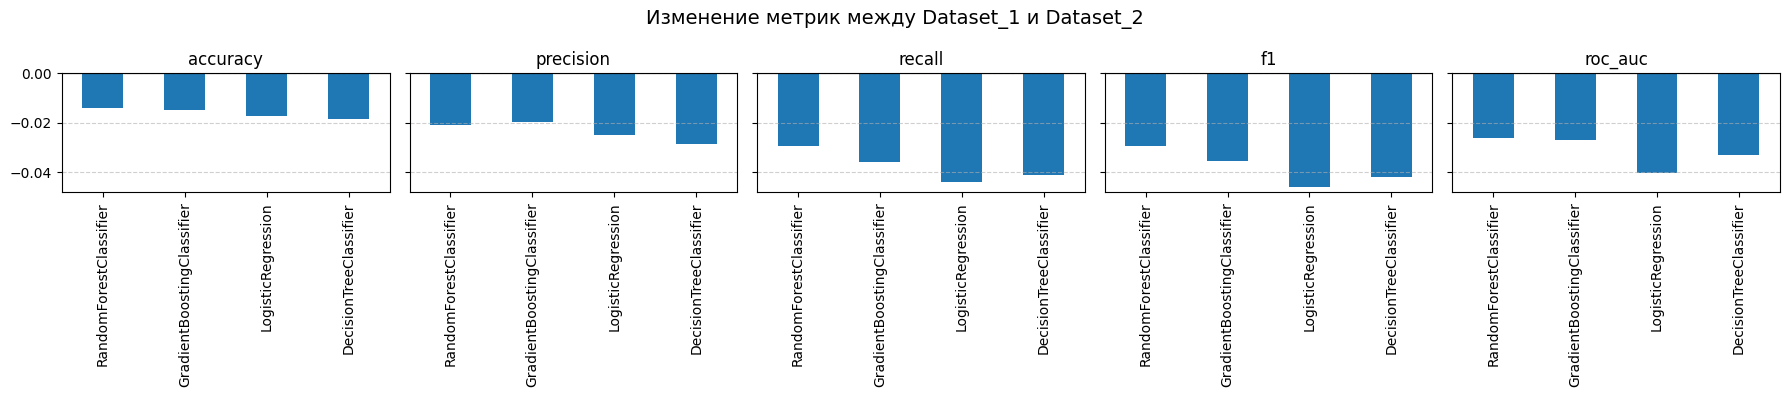

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0140,-0.0209,-0.0293,-0.0294,-0.0263
GradientBoostingClassifier,-0.0149,-0.0197,-0.0357,-0.0356,-0.0269
LogisticRegression,-0.0174,-0.0249,-0.0438,-0.0459,-0.0405
DecisionTreeClassifier,-0.0184,-0.0287,-0.0413,-0.0418,-0.0330


In [28]:
compare_datasets_results(initial_metrics, Diff_metrics_delete)#Видим что результаты только ухудшились

In [29]:
X_train_preprocessed_3days = X.copy()

# Добавляем колонку даты
X_train_preprocessed_3days['Date'] = pd.to_datetime(
    X_train_preprocessed_3days[['Year', 'Month', 'Day']]
)

# Сортировка по Location и дате
X_train_preprocessed_3days = (
    X_train_preprocessed_3days
    .sort_values(['Location', 'Date'])
    .reset_index(drop=True)
)

# Создаём отдельную копию y с синхронизированным индексом
y_3days = y.reset_index(drop=True)


for col in ['RainToday', 'MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'Humidity3pm']:
    X_train_preprocessed_3days[f'{col}_3'] = (
        X_train_preprocessed_3days
        .groupby('Location')[col]
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    )

# Убираем вспомогательную колонку
X_train_preprocessed_3days.drop(columns=['Date'], inplace=True)

#Сгруппировали по локации и дате и объединили для 3 предыдущих дней

In [30]:
days3_metrics =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_3days,
    y=y_3days,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7758
Precision: 0.3879
Recall:    0.5000
F1 Score:  0.4369
ROC AUC:   0.5083

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.7697
Precision: 0.5223
Recall:    0.5017
F1 Score:  0.4497
ROC AUC:   0.5752

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.7752
Precision: 0.5642
Recall:    0.5009
F1 Score:  0.4402
ROC AUC:   0.5786

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.7757
Precision: 0.4573
Recall:    0.5000
F1 Score:  0.4370
ROC AUC:   0.5860

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
GradientBoostingClassifier    0.7757     0.4573  0.5000 0.4370   0.5860
RandomForestClassifier        0.7752     0.5642  0.5009 0.4402   0.5786
DecisionTreeClassifier        0.7697     0.5223  0.5017 0.4497   0.5752
LogisticRegression            0.7758     0.3879  0.5000 0.4369   0.5083



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0798    -0.2531 -0.2318 -0.3213  -0.3020
GradientBoostingClassifier   -0.0725    -0.3488 -0.2205 -0.3118  -0.2805
LogisticRegression           -0.0607    -0.3992 -0.1972 -0.2879  -0.3351
DecisionTreeClassifier       -0.0696    -0.2626 -0.2116 -0.2883  -0.2650


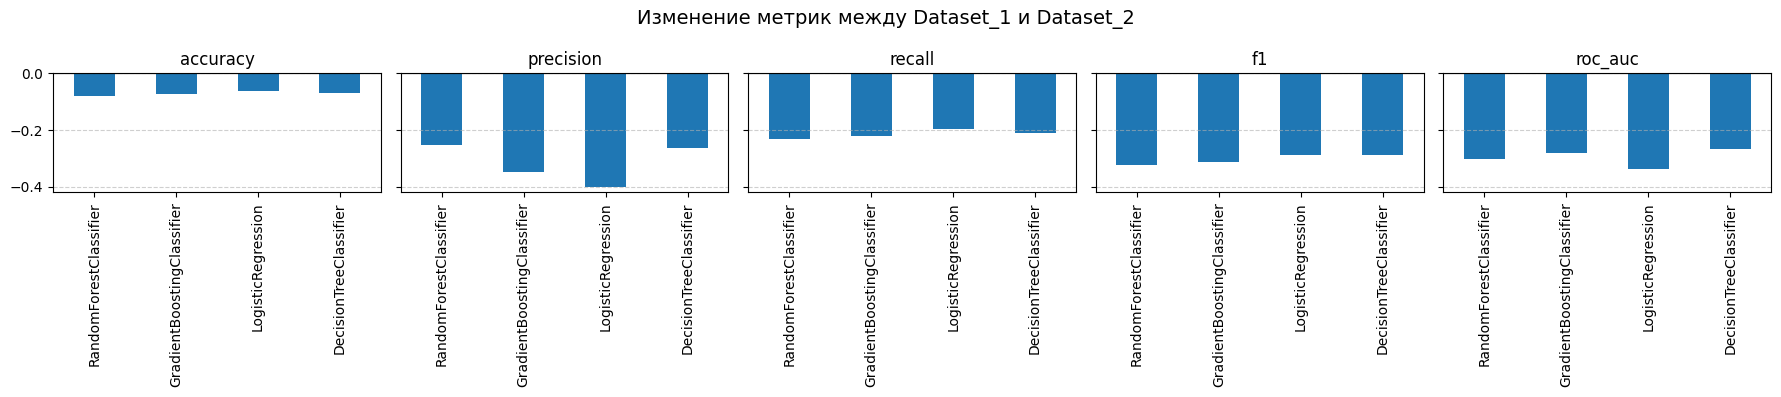

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0798,-0.2531,-0.2318,-0.3213,-0.3020
GradientBoostingClassifier,-0.0725,-0.3488,-0.2205,-0.3118,-0.2805
LogisticRegression,-0.0607,-0.3992,-0.1972,-0.2879,-0.3351
DecisionTreeClassifier,-0.0696,-0.2626,-0.2116,-0.2883,-0.2650


In [31]:
compare_datasets_results(initial_metrics, days3_metrics)#Сильно ухудшились результаты

In [32]:
#Добавили Smote, то есть генерацию синтетических данных для каждого фолда
Smote_metrics_new =evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=5,
    seed=SEED, 
    use_smote=True
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7743
Precision: 0.7058
Recall:    0.7637
F1 Score:  0.7199
ROC AUC:   0.8434

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8002
Precision: 0.7196
Recall:    0.7477
F1 Score:  0.7308
ROC AUC:   0.8328

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8486
Precision: 0.7866
Recall:    0.7611
F1 Score:  0.7724
ROC AUC:   0.8789

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8238
Precision: 0.7473
Recall:    0.7599
F1 Score:  0.7531
ROC AUC:   0.8558

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8486     0.7866  0.7611 0.7724   0.8789
GradientBoostingClassifier    0.8238     0.7473  0.7599 0.7531   0.8558
LogisticRegression            0.7743     0.7058  0.7637 0.7199   0.8434
DecisionTreeClassifier        0.8002     0.7196  0.7477 0.7308   0.8328



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0064    -0.0307  0.0284  0.0109  -0.0016
GradientBoostingClassifier   -0.0244    -0.0589  0.0395  0.0043  -0.0107
LogisticRegression           -0.0622    -0.0814  0.0665 -0.0048  -0.0000
DecisionTreeClassifier       -0.0391    -0.0653  0.0344 -0.0071  -0.0074


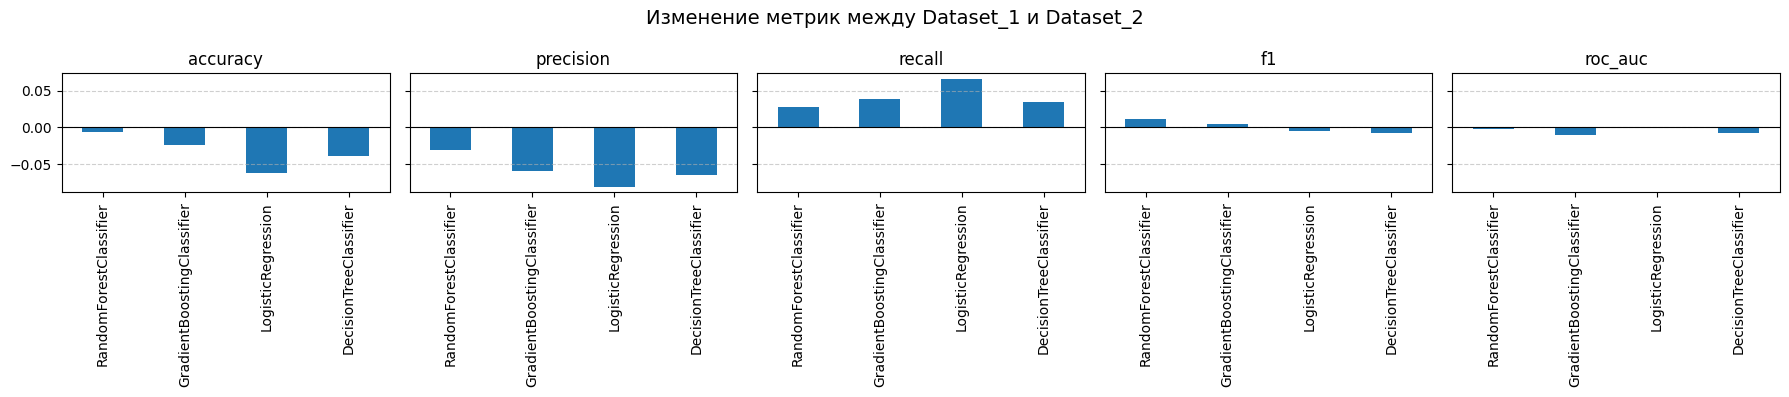

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0064,-0.0307,0.0284,0.0109,-0.0016
GradientBoostingClassifier,-0.0244,-0.0589,0.0395,0.0043,-0.0107
LogisticRegression,-0.0622,-0.0814,0.0665,-0.0048,-0.0000
DecisionTreeClassifier,-0.0391,-0.0653,0.0344,-0.0071,-0.0074


In [33]:
compare_datasets_results(initial_metrics, Smote_metrics_new)#Увеличился recall, но стал хуже precision, accuracy, roc_auc, также видим увелечение f1score везде кроме лог рег

In [34]:
#Проверяем улучшатся ли показатель при добавлении аргумента class_weight='balanced'
models_weight = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, class_weight='balanced')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=10, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=SEED))
]

In [35]:
initial_metrics_class_weight = evaluate_models_cv(
    models=models_weight,
    X=X,
    y=y,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7749
Precision: 0.7061
Recall:    0.7635
F1 Score:  0.7203
ROC AUC:   0.8438

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.7835
Precision: 0.7124
Recall:    0.7668
F1 Score:  0.7275
ROC AUC:   0.8388

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8520
Precision: 0.8198
Recall:    0.7193
F1 Score:  0.7508
ROC AUC:   0.8814

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8482
Precision: 0.8061
Recall:    0.7204
F1 Score:  0.7488
ROC AUC:   0.8665

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8520     0.8198  0.7193 0.7508   0.8814
GradientBoostingClassifier    0.8482     0.8061  0.7204 0.7488   0.8665
LogisticRegression            0.7749     0.7061  0.7635 0.7203   0.8438
DecisionTreeClassifier        0.7835     0.7124  0.7668 0.7275   0.8388



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0029     0.0024 -0.0134 -0.0108   0.0009
GradientBoostingClassifier    0.0000     0.0000  0.0000  0.0000   0.0000
LogisticRegression           -0.0616    -0.0811  0.0664 -0.0044   0.0004
DecisionTreeClassifier       -0.0558    -0.0725  0.0535 -0.0104  -0.0014


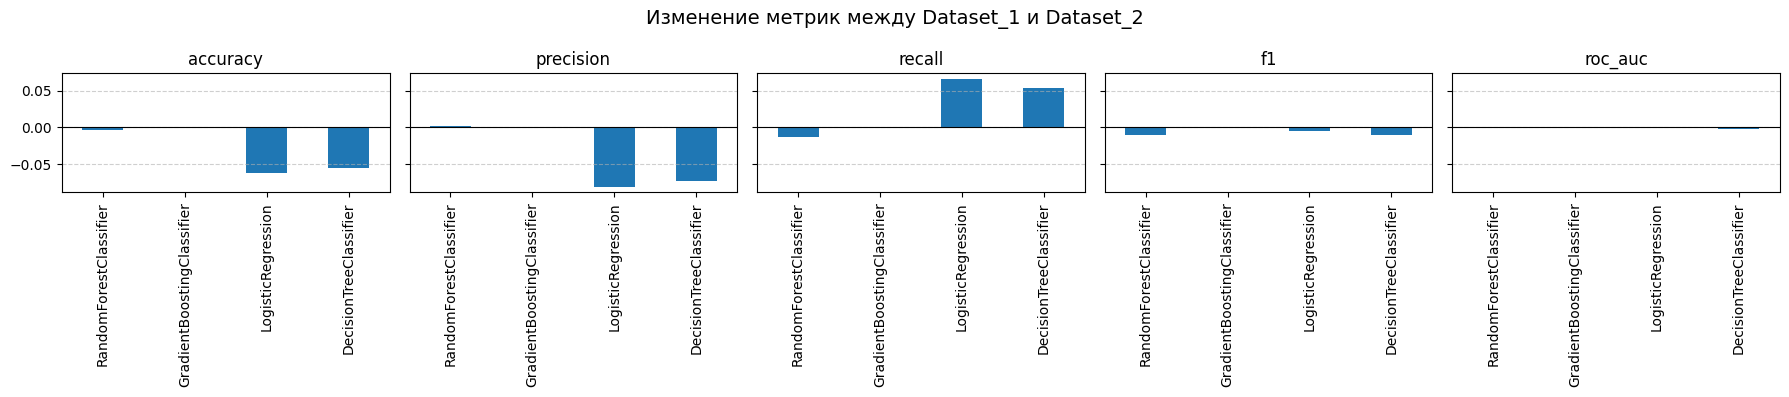

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0029,0.0024,-0.0134,-0.0108,0.0009
GradientBoostingClassifier,0.0000,0.0000,0.0000,0.0000,0.0000
LogisticRegression,-0.0616,-0.0811,0.0664,-0.0044,0.0004
DecisionTreeClassifier,-0.0558,-0.0725,0.0535,-0.0104,-0.0014


In [36]:
compare_datasets_results(initial_metrics, initial_metrics_class_weight)#результаты  ухудшились

In [37]:
#Используем разницу между мин макс температурой и разницу по времени у других признаков, так как это может влиять на прогноз модели, также добавляем smote
Diff_metrics_smote =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_diff,
    y=y,
    cv=cv,
    seed=SEED, 
    use_smote=True
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7737
Precision: 0.7057
Recall:    0.7643
F1 Score:  0.7198
ROC AUC:   0.8448

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8083
Precision: 0.7286
Recall:    0.7526
F1 Score:  0.7387
ROC AUC:   0.8370

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8488
Precision: 0.7856
Recall:    0.7669
F1 Score:  0.7754
ROC AUC:   0.8812

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8265
Precision: 0.7510
Recall:    0.7631
F1 Score:  0.7566
ROC AUC:   0.8600

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8488     0.7856  0.7669 0.7754   0.8812
GradientBoostingClassifier    0.8265     0.7510  0.7631 0.7566   0.8600
LogisticRegression            0.7737     0.7057  0.7643 0.7198   0.8448
DecisionTreeClassifier        0.8083     0.7286  0.7526 0.7387   0.8370



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0061    -0.0317  0.0342  0.0139   0.0007
GradientBoostingClassifier   -0.0217    -0.0552  0.0426  0.0078  -0.0065
LogisticRegression           -0.0628    -0.0814  0.0671 -0.0050   0.0013
DecisionTreeClassifier       -0.0310    -0.0563  0.0393  0.0007  -0.0032


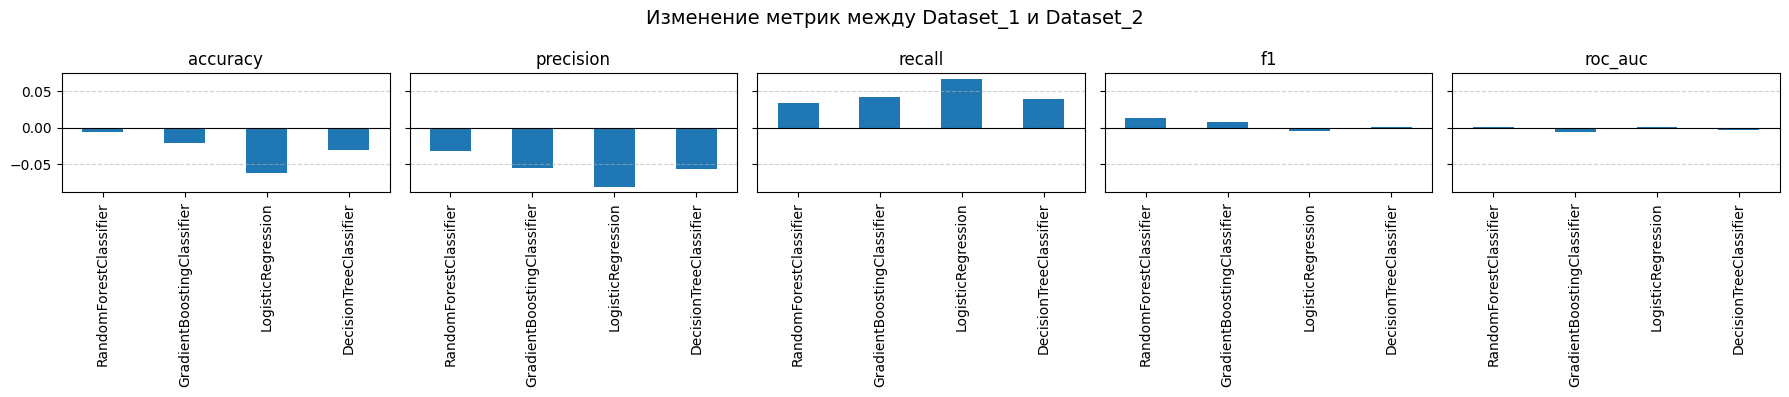

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0061,-0.0317,0.0342,0.0139,0.0007
GradientBoostingClassifier,-0.0217,-0.0552,0.0426,0.0078,-0.0065
LogisticRegression,-0.0628,-0.0814,0.0671,-0.0050,0.0013
DecisionTreeClassifier,-0.0310,-0.0563,0.0393,0.0007,-0.0032


In [38]:
compare_datasets_results(initial_metrics, Diff_metrics_smote)#везде кроме лог рег увеличился f1 score


=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier        0.0002    -0.0010  0.0057  0.0030   0.0023
GradientBoostingClassifier    0.0028     0.0037  0.0032  0.0035   0.0042
LogisticRegression           -0.0005    -0.0000  0.0006 -0.0001   0.0013
DecisionTreeClassifier        0.0081     0.0090  0.0049  0.0078   0.0042


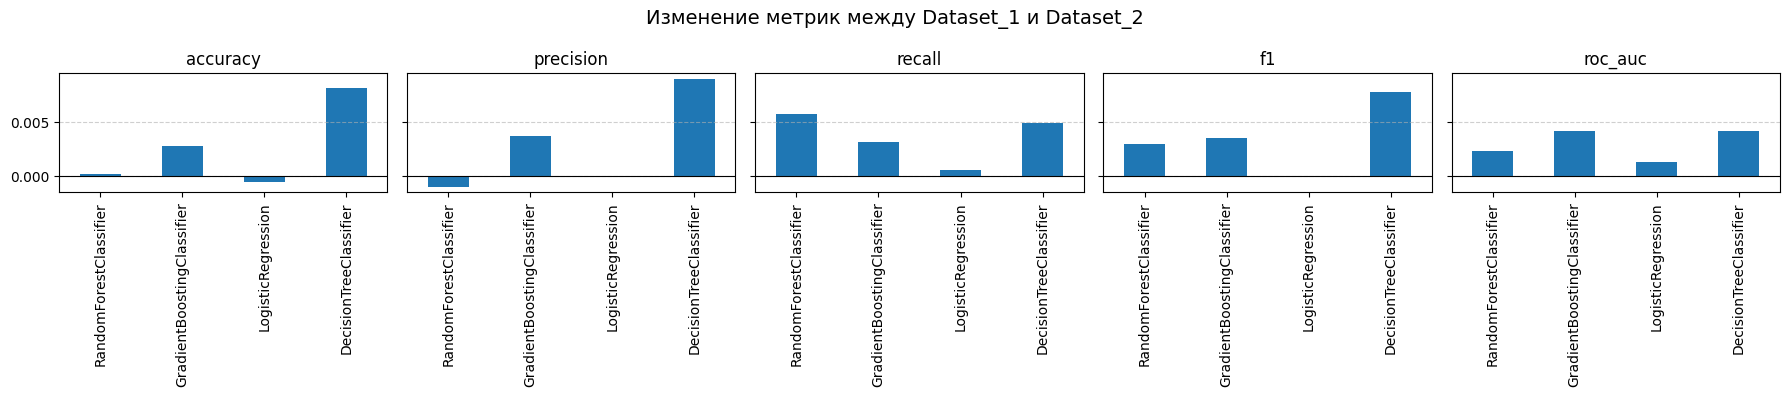

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,0.0002,-0.0010,0.0057,0.0030,0.0023
GradientBoostingClassifier,0.0028,0.0037,0.0032,0.0035,0.0042
LogisticRegression,-0.0005,-0.0000,0.0006,-0.0001,0.0013
DecisionTreeClassifier,0.0081,0.0090,0.0049,0.0078,0.0042


In [39]:
compare_datasets_results(Smote_metrics_new, Diff_metrics_smote)#сравниваем с метриками обычного smote, так как у него был наилучший f1 score среди всех вариантов

In [ ]:
#Видим что лучший F1 SCORE если Smote + diff для рэндом фореста

In [ ]:

# --- Определяем числовые и категориальные признаки ---
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# --- Трансформеры ---
num_transformer = SimpleImputer(strategy='mean')
cat_transformer = TargetEncoder(handle_unknown='value', handle_missing='value', 
                                min_samples_leaf=5, smoothing=10)

# --- ColumnTransformer ---
preprocessor_smote = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='drop'
)

# --- Пайплайн с SMOTE ---
pipeline_smote = ImbPipeline([
    ('preprocessor', preprocessor_smote),
    ('smote', SMOTE(random_state=SEED)),
    ('model', RandomForestClassifier(random_state=SEED))
])

# --- Сетка гиперпараметров ---
param_grid = {
    "model__n_estimators": [50, 100, 200, 500],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10]
}

# --- RandomizedSearchCV ---
grid = RandomizedSearchCV(
    estimator=pipeline_smote,
    param_distributions=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=SEED,
    n_iter=10
)

# --- Обучение ---
grid.fit(X_train_preprocessed_diff, y)

# --- Результаты ---
best_model = grid.best_estimator_
print(f"Best params: {grid.best_params_}, best F1: {grid.best_score_:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__max_depth': 10}, best F1: 0.7932


In [ ]:

#Best params: {'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__max_depth': 10}, best F1: 0.7932